In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

In [2]:
from jax import jit, grad, vmap, hessian, value_and_grad
import optax

In [3]:
def discrete_sine_transform(y):
    n = y.shape[0] +1
    y_extended = jnp.concatenate([y, jnp.array([0]), -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1]

In [4]:
def evaluate_function_sine(x, k ,c):
    return c*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x)
def evaluate_basis_sine(x,c):
    frequencies = jnp.arange(1, c.shape[0]+1)
    return jnp.sum(vmap(evaluate_function_sine, in_axes=(0,None,None))(x, frequencies, c), axis=1)

In [5]:
key = random.PRNGKey(635)
nu = 0.01
n_coef = 2**13
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1)
print(n_coef)

frequencies = jnp.arange(1, n_coef+1)
coef_f = random.normal(key, shape= (n_coef,))
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


8192


In [6]:
# We include both 0 and 1 in the domain
domain_finest = jnp.linspace(lower,upper,n_coef+1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

In [7]:
u_transform = discrete_sine_transform(u_values)
f_transform = discrete_sine_transform(f_values)

In [8]:
jnp.mean((u_transform[:-1] - coef_u)**2), jnp.mean((f_transform[:-1] - coef_f)**2)

(Array(0.000306, dtype=float64), Array(1.53517604, dtype=float64))

In [9]:
# We do not include both 0 and 1 in the domain
domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

In [10]:
domain_finest.shape

(8193,)

In [11]:
u_transform = discrete_sine_transform(u_values)
f_transform = discrete_sine_transform(f_values)

In [12]:
jnp.mean((u_transform[:-1] - coef_u)**2), jnp.mean((f_transform[:-1] - coef_f)**2)

(Array(0.00030589, dtype=float64), Array(1.32921151, dtype=float64))

In [13]:
# We do not include both 0 and 1 in the domain
domain_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

In [19]:
domain_finest

Array([0.00000000e+00, 1.22070312e-04, 2.44140625e-04, ...,
       9.99633789e-01, 9.99755859e-01, 9.99877930e-01], dtype=float64)

In [14]:
n_coef, domain_finest.shape, u_values.shape

(8192, (8192,), (8192,))

In [15]:
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))

In [16]:
u_transform = discrete_sine_transform(u_values)
f_transform = discrete_sine_transform(f_values)

In [17]:
u_transform.shape, coef_f.shape

((8193,), (8192,))

In [18]:
jnp.mean((u_transform[1:] - coef_u)**2), jnp.mean((f_transform[1:] - coef_f)**2)

(Array(1.3878491e-10, dtype=float64), Array(0.49758865, dtype=float64))

In [20]:
u_values

Array([0.        , 0.00196666, 0.00387146, ..., 0.00388946, 0.00261485,
       0.00131249], dtype=float64)

In [141]:
f_test = lambda x : x**2+1 + x**3 - 3*x**4 + x

In [142]:
f_test_values = f_test(domain_finest)

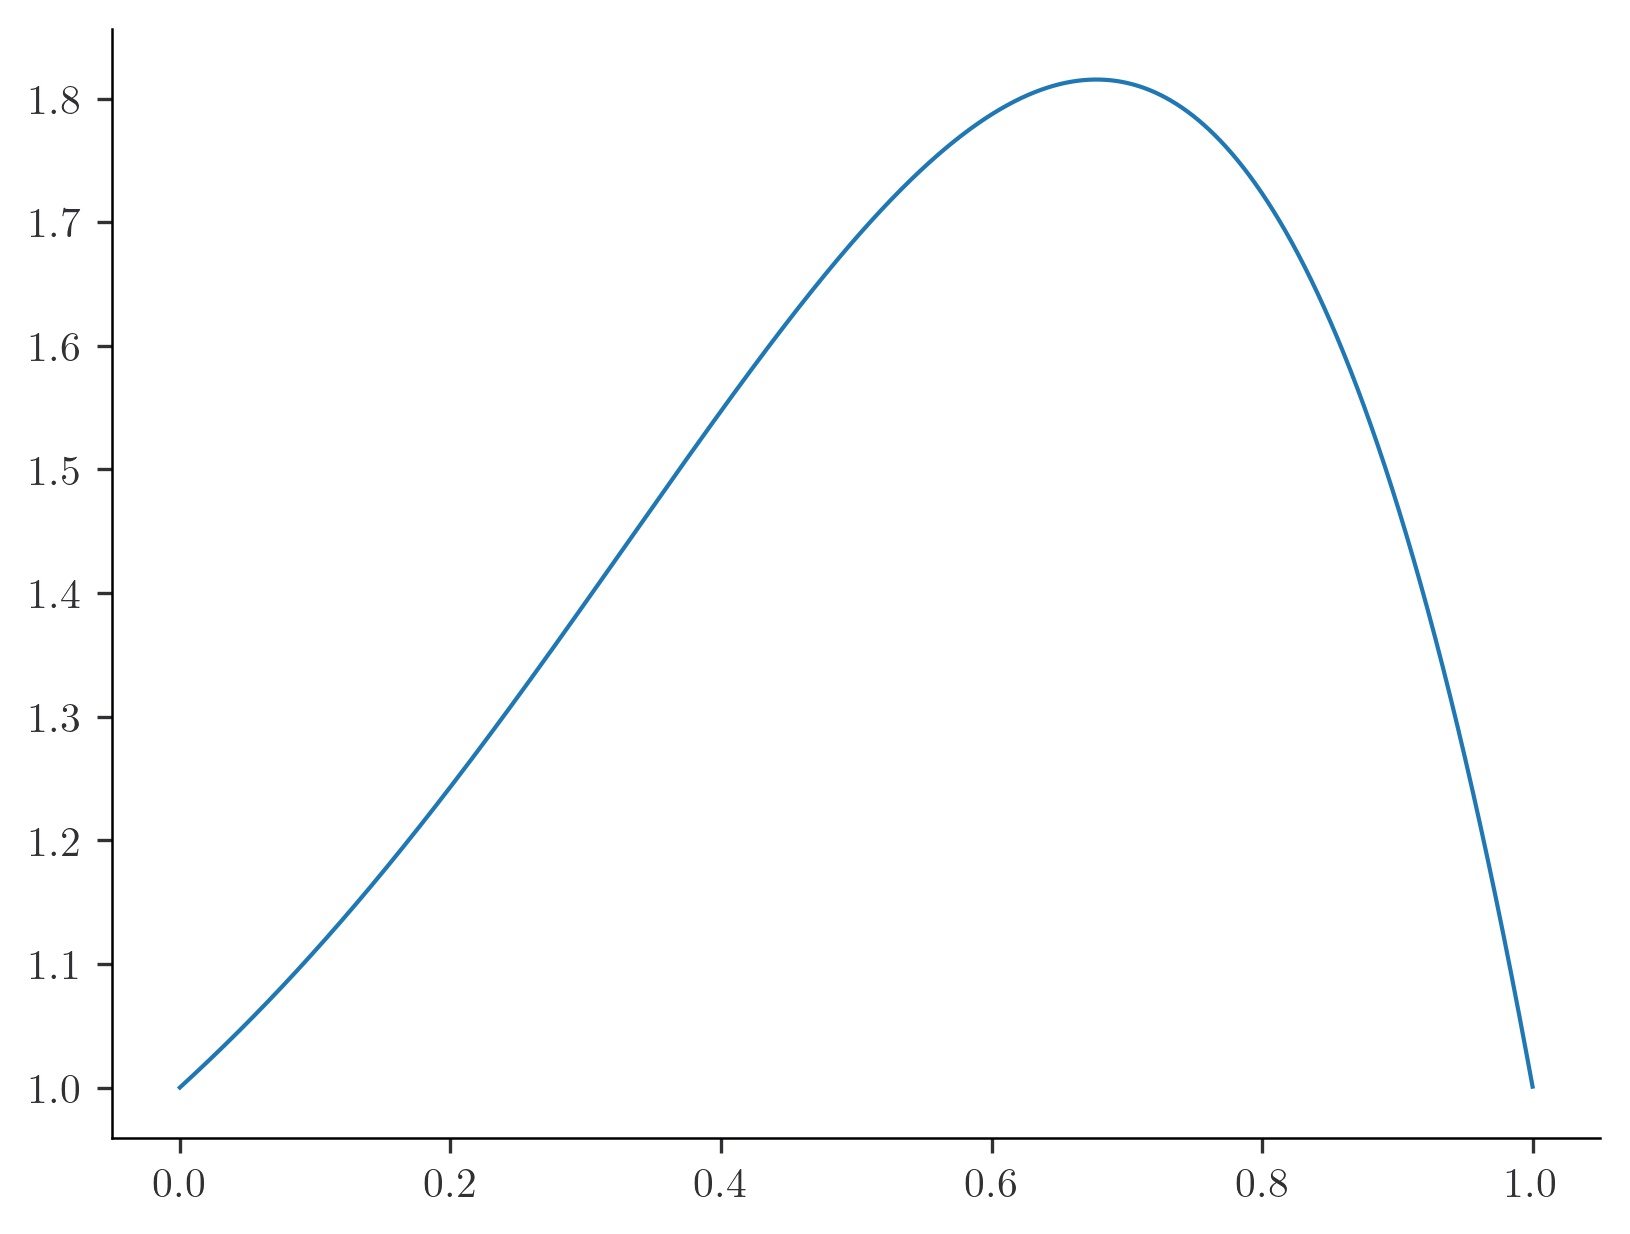

In [143]:
plt.plot(domain_finest, f_test_values)

In [144]:
f_transformed = discrete_sine_transform(f_test_values)

(16384,)
(8193,)


In [145]:
# Manual computation of the using quadrature
from scipy import integrate

domain_full = jnp.linspace(lower,upper,n_coef)

In [146]:
def integrate_sine(points, k, f_values):
     G = f_values*jnp.sqrt(2)*jnp.sin(jnp.pi*k*points)
     return integrate.trapezoid(G, points)

In [147]:
f_values = f_test(domain_full)

In [148]:
max_freq = n_coef
k_list = jnp.arange(0, max_freq)
integral_manual = jnp.array([integrate_sine(domain_full, k,  f_test(domain_full)) for k in k_list])

In [149]:
jnp.mean((integral_manual - f_transformed[:max_freq])**2)

Array(1.86504091e-12, dtype=float64)

In [150]:
k = 2
integrate_sine(domain_full, k, f_test(domain_full))

-0.17103959026040072

In [101]:
f_transformed[k]

Array(0.44338267, dtype=float64)

In [70]:
domain_full.shape

(8192,)

In [67]:
domain_finest[-1]

Array(0.99987793, dtype=float64)

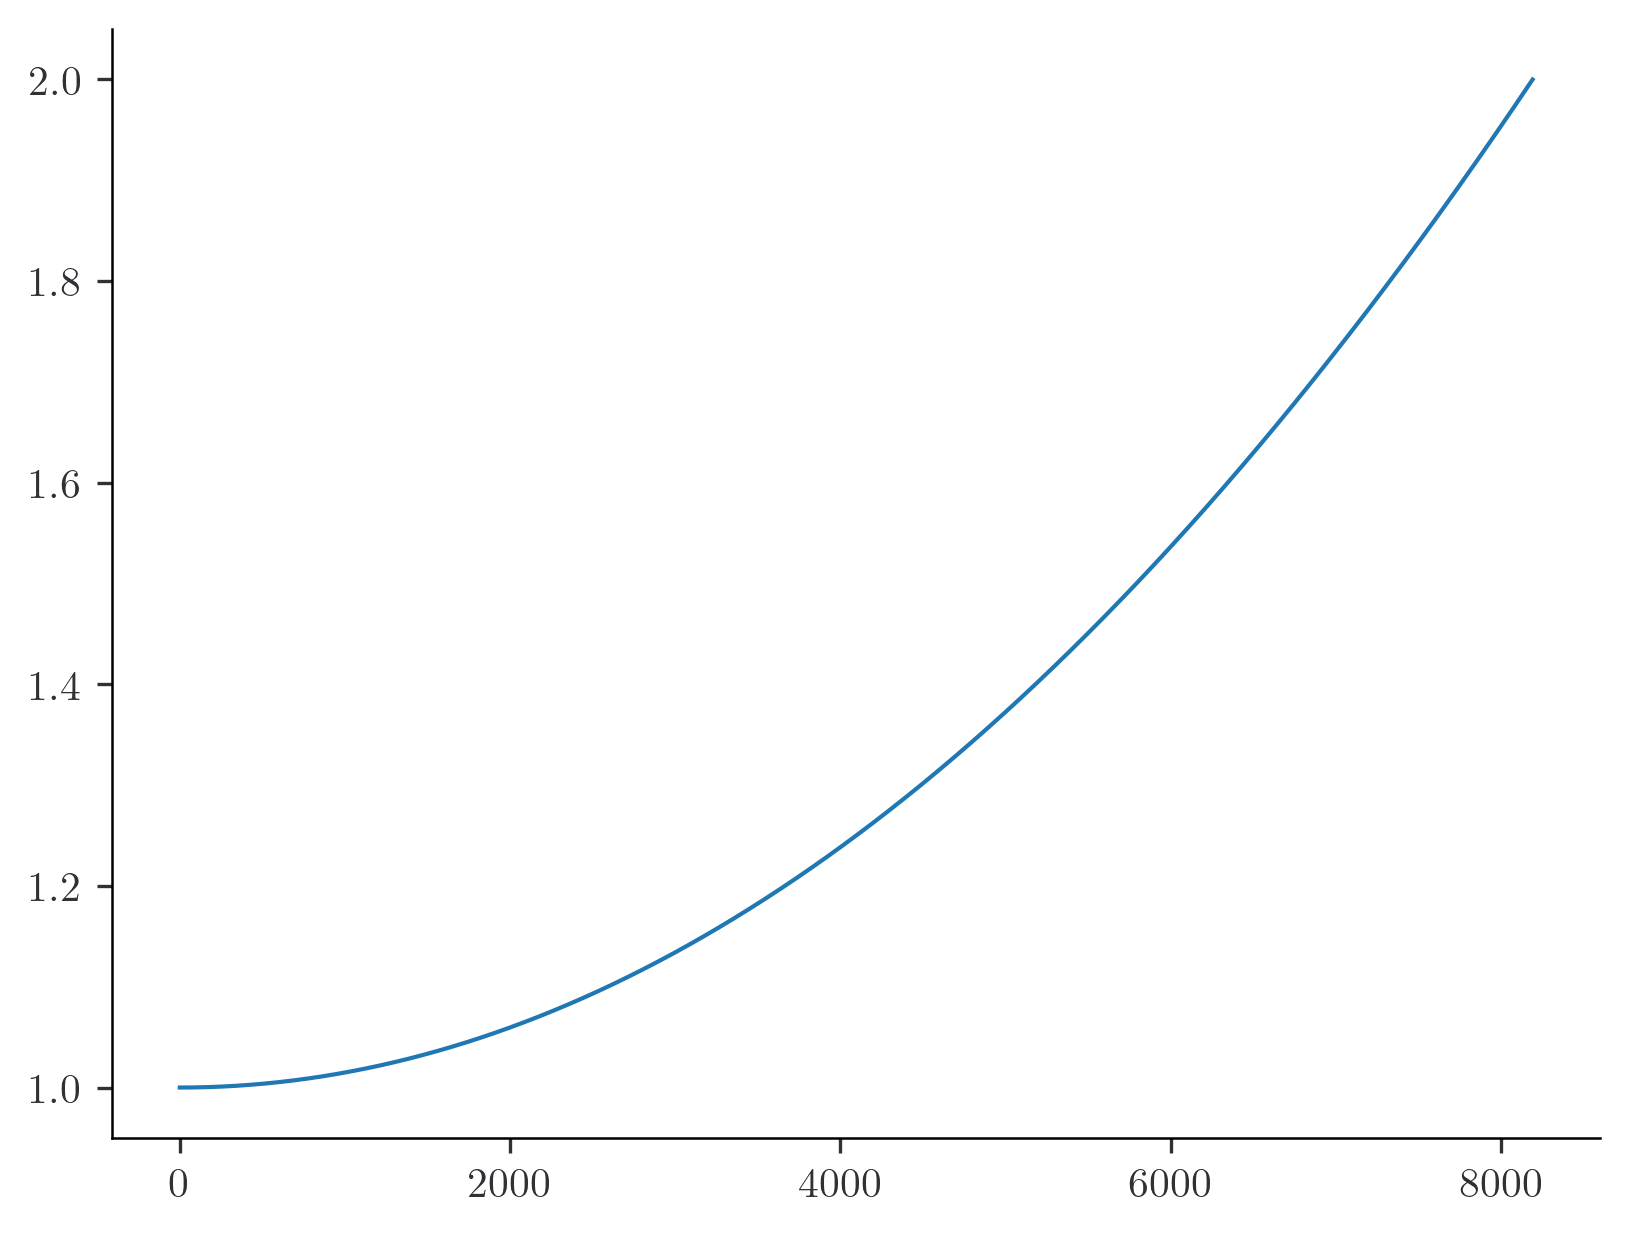

In [63]:
plt.plot(f_test_values)

In [12]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

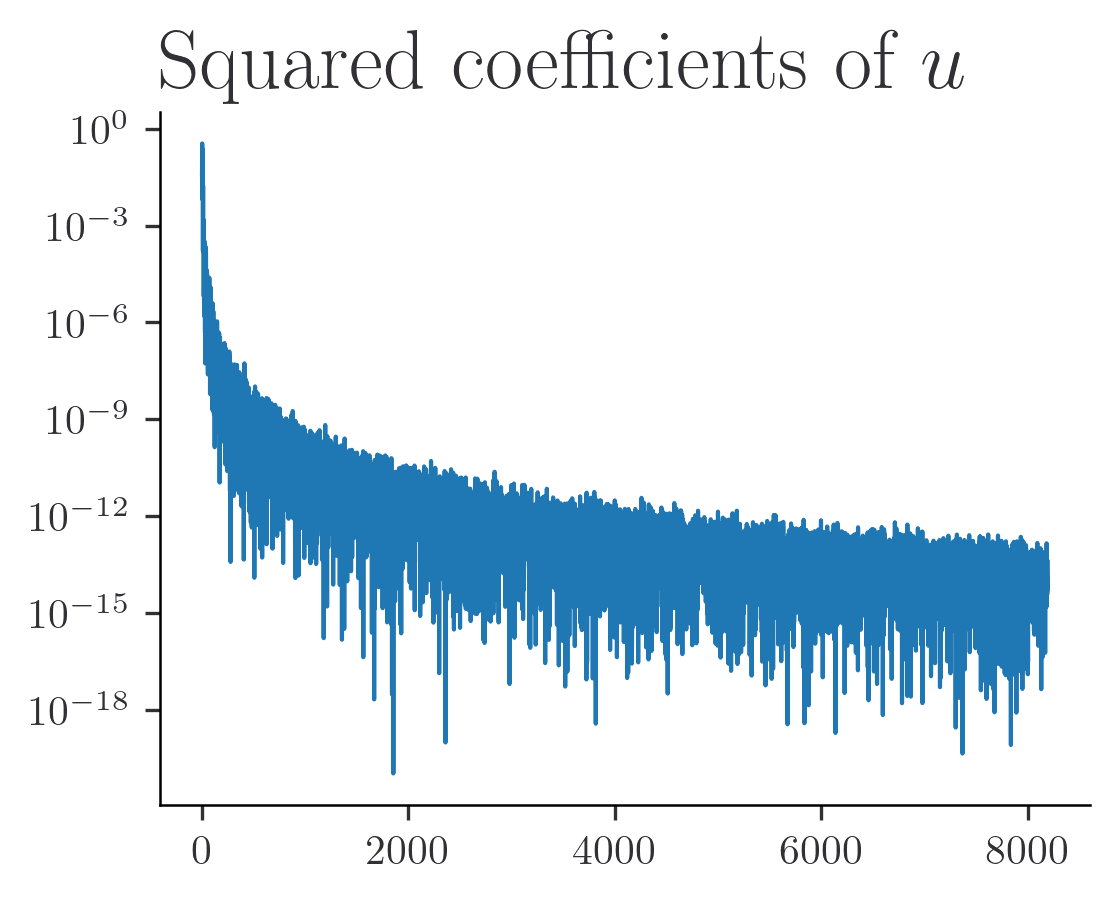

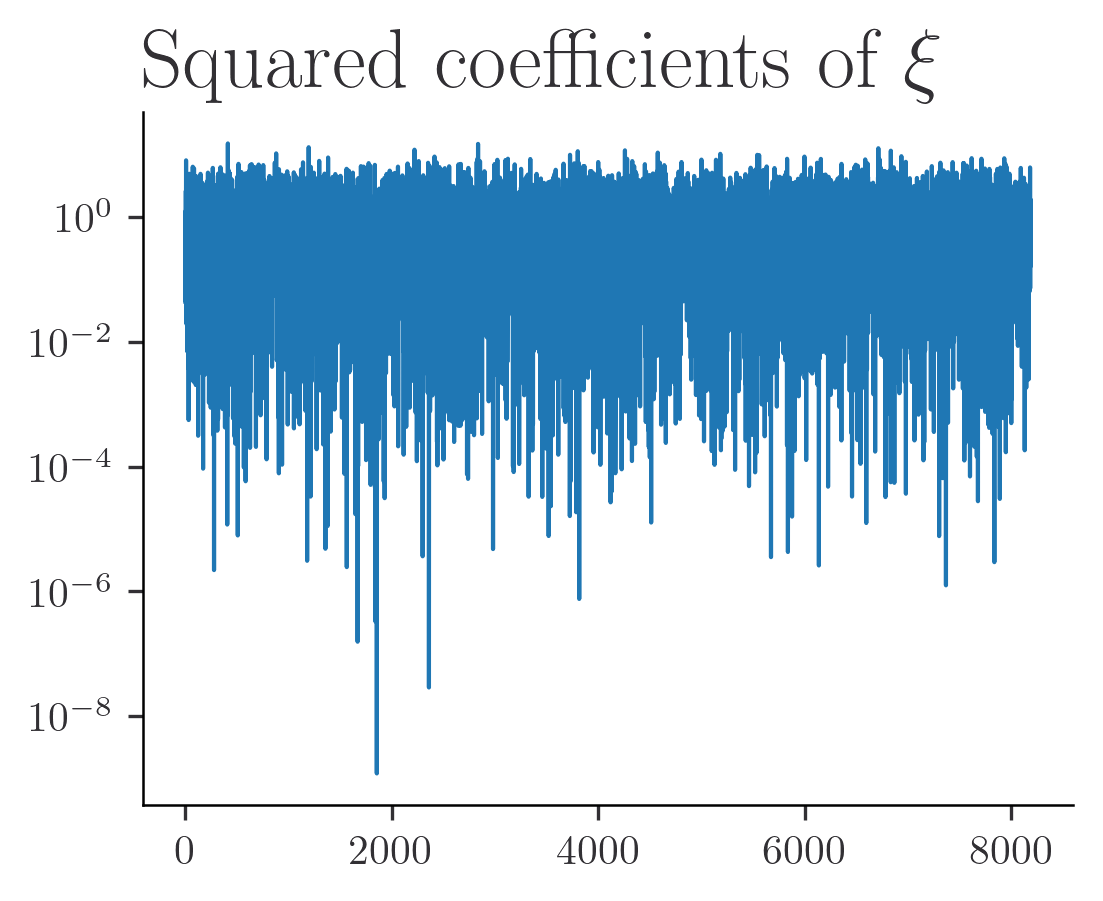

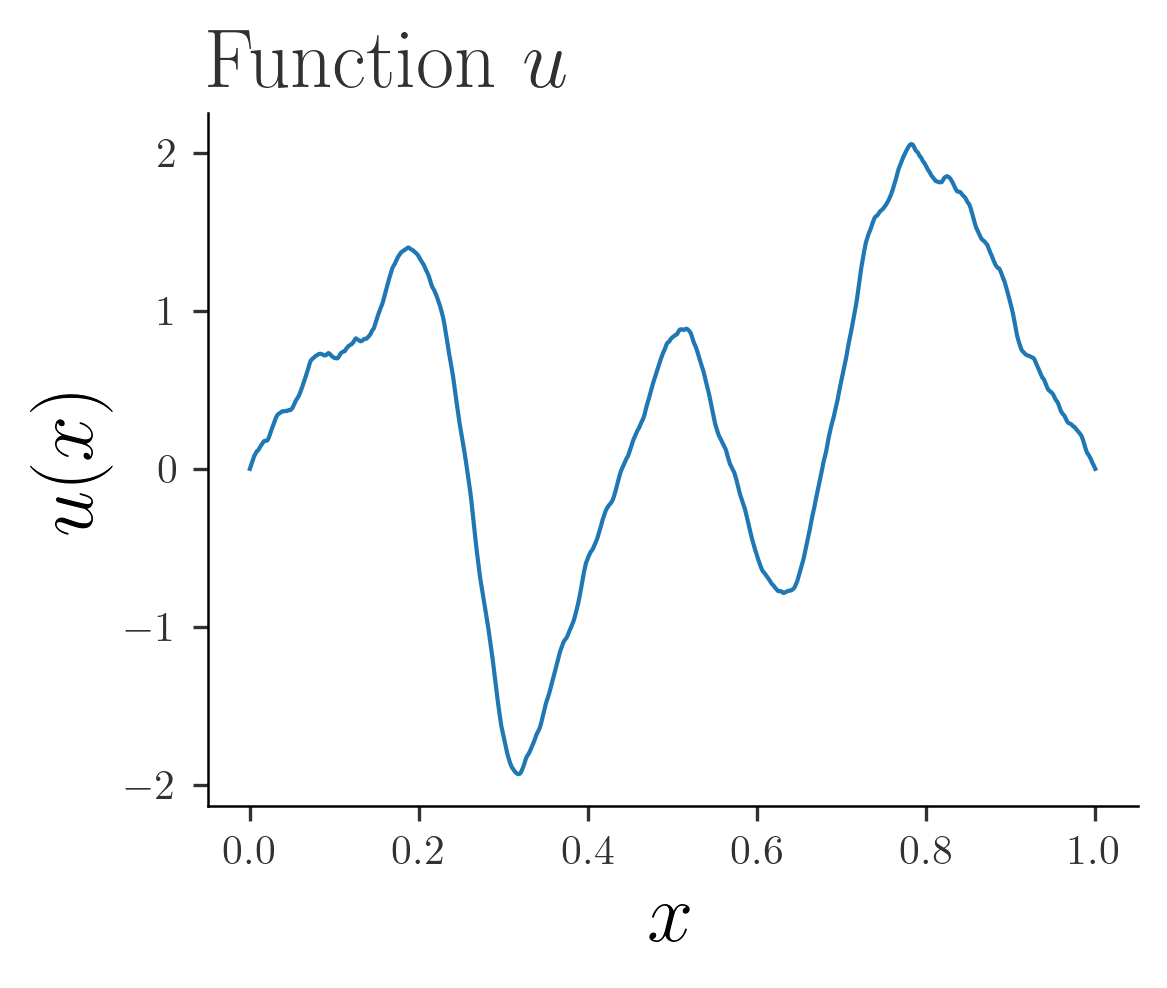

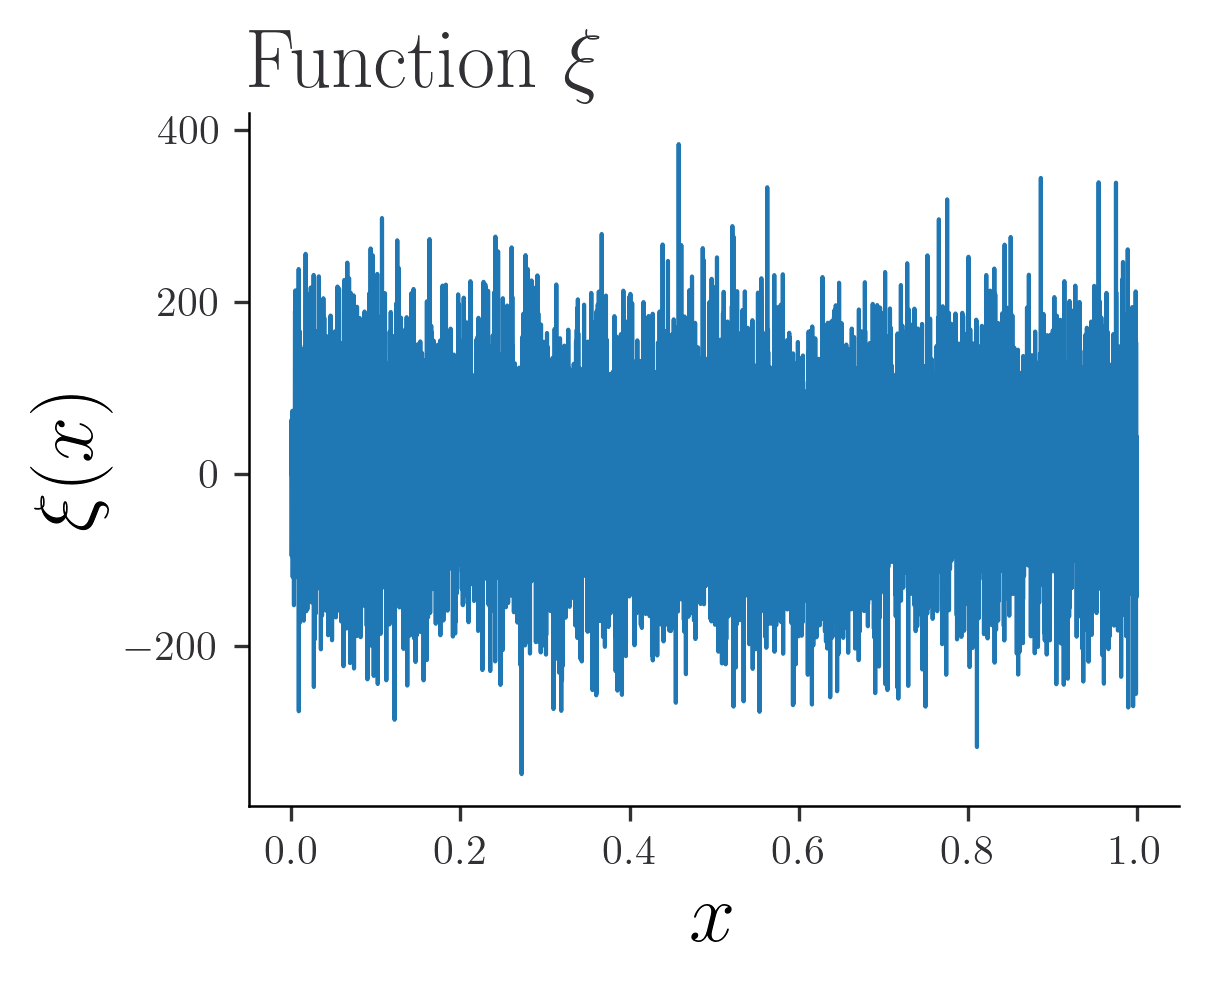

In [ ]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()